In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/659 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                  | 1/659 [00:00<07:17,  1.50it/s]

  0%|▍                                                                                                                                                  | 2/659 [00:00<03:44,  2.92it/s]

  1%|▉                                                                                                                                                  | 4/659 [00:00<02:01,  5.39it/s]

  1%|█▎                                                                                                                                                 | 6/659 [00:01<01:32,  7.06it/s]

  1%|█▊                                                                                                                                                 | 8/659 [00:01<01:19,  8.21it/s]

  2%|██▏                                                                                                                                               | 10/659 [00:01<01:12,  9.00it/s]

  2%|██▋                                                                                                                                               | 12/659 [00:01<01:07,  9.55it/s]

  2%|███                                                                                                                                               | 14/659 [00:01<01:04,  9.93it/s]

  2%|███▌                                                                                                                                              | 16/659 [00:02<01:03, 10.20it/s]

  3%|███▉                                                                                                                                              | 18/659 [00:02<01:01, 10.38it/s]

  3%|████▍                                                                                                                                             | 20/659 [00:02<01:00, 10.51it/s]

  3%|████▊                                                                                                                                             | 22/659 [00:02<01:00, 10.60it/s]

  4%|█████▎                                                                                                                                            | 24/659 [00:02<00:59, 10.66it/s]

  4%|█████▊                                                                                                                                            | 26/659 [00:03<00:59, 10.70it/s]

  4%|██████▏                                                                                                                                           | 28/659 [00:03<00:58, 10.73it/s]

  5%|██████▋                                                                                                                                           | 30/659 [00:03<00:58, 10.76it/s]

  5%|███████                                                                                                                                           | 32/659 [00:03<00:58, 10.77it/s]

  5%|███████▌                                                                                                                                          | 34/659 [00:03<00:57, 10.78it/s]

  5%|███████▉                                                                                                                                          | 36/659 [00:03<00:57, 10.79it/s]

  6%|████████▍                                                                                                                                         | 38/659 [00:04<00:57, 10.79it/s]

  6%|████████▊                                                                                                                                         | 40/659 [00:04<00:57, 10.79it/s]

  6%|█████████▎                                                                                                                                        | 42/659 [00:04<00:57, 10.80it/s]

  7%|█████████▋                                                                                                                                        | 44/659 [00:04<00:56, 10.80it/s]

  7%|██████████▏                                                                                                                                       | 46/659 [00:04<00:56, 10.79it/s]

  7%|██████████▋                                                                                                                                       | 48/659 [00:05<00:56, 10.80it/s]

  8%|███████████                                                                                                                                       | 50/659 [00:05<00:56, 10.80it/s]

  8%|███████████▌                                                                                                                                      | 52/659 [00:05<00:56, 10.80it/s]

  8%|███████████▉                                                                                                                                      | 54/659 [00:05<00:56, 10.80it/s]

  8%|████████████▍                                                                                                                                     | 56/659 [00:05<00:55, 10.80it/s]

  9%|████████████▊                                                                                                                                     | 58/659 [00:05<00:55, 10.80it/s]

  9%|█████████████▎                                                                                                                                    | 60/659 [00:06<00:55, 10.80it/s]

  9%|█████████████▋                                                                                                                                    | 62/659 [00:06<00:55, 10.80it/s]

 10%|██████████████▏                                                                                                                                   | 64/659 [00:06<00:55, 10.81it/s]

 10%|██████████████▌                                                                                                                                   | 66/659 [00:06<00:54, 10.80it/s]

 10%|███████████████                                                                                                                                   | 68/659 [00:06<00:54, 10.80it/s]

 11%|███████████████▌                                                                                                                                  | 70/659 [00:07<00:54, 10.80it/s]

 11%|███████████████▉                                                                                                                                  | 72/659 [00:07<00:54, 10.80it/s]

 11%|████████████████▍                                                                                                                                 | 74/659 [00:07<00:54, 10.80it/s]

 12%|████████████████▊                                                                                                                                 | 76/659 [00:07<00:53, 10.80it/s]

 12%|█████████████████▎                                                                                                                                | 78/659 [00:07<00:53, 10.80it/s]

 12%|█████████████████▋                                                                                                                                | 80/659 [00:08<00:53, 10.80it/s]

 12%|██████████████████▏                                                                                                                               | 82/659 [00:08<00:53, 10.80it/s]

 13%|██████████████████▌                                                                                                                               | 84/659 [00:08<00:53, 10.80it/s]

 13%|███████████████████                                                                                                                               | 86/659 [00:08<00:53, 10.81it/s]

 13%|███████████████████▍                                                                                                                              | 88/659 [00:08<00:52, 10.80it/s]

 14%|███████████████████▉                                                                                                                              | 90/659 [00:08<00:52, 10.81it/s]

 14%|████████████████████▍                                                                                                                             | 92/659 [00:09<00:52, 10.81it/s]

 14%|████████████████████▊                                                                                                                             | 94/659 [00:09<00:52, 10.81it/s]

 15%|█████████████████████▎                                                                                                                            | 96/659 [00:09<00:52, 10.80it/s]

 15%|█████████████████████▋                                                                                                                            | 98/659 [00:09<00:51, 10.81it/s]

 15%|██████████████████████                                                                                                                           | 100/659 [00:09<00:51, 10.81it/s]

 15%|██████████████████████▍                                                                                                                          | 102/659 [00:10<00:51, 10.80it/s]

 16%|██████████████████████▉                                                                                                                          | 104/659 [00:10<00:51, 10.81it/s]

 16%|███████████████████████▎                                                                                                                         | 106/659 [00:10<00:51, 10.81it/s]

 16%|███████████████████████▊                                                                                                                         | 108/659 [00:10<00:51, 10.80it/s]

 17%|████████████████████████▏                                                                                                                        | 110/659 [00:10<00:50, 10.78it/s]

 17%|████████████████████████▋                                                                                                                        | 112/659 [00:10<00:50, 10.78it/s]

 17%|█████████████████████████                                                                                                                        | 114/659 [00:11<00:50, 10.79it/s]

 18%|█████████████████████████▌                                                                                                                       | 116/659 [00:11<00:50, 10.79it/s]

 18%|█████████████████████████▉                                                                                                                       | 118/659 [00:11<00:50, 10.80it/s]

 18%|██████████████████████████▍                                                                                                                      | 120/659 [00:11<00:49, 10.80it/s]

 19%|██████████████████████████▊                                                                                                                      | 122/659 [00:11<00:49, 10.79it/s]

 19%|███████████████████████████▎                                                                                                                     | 124/659 [00:12<00:49, 10.79it/s]

 19%|███████████████████████████▋                                                                                                                     | 126/659 [00:12<00:49, 10.80it/s]

 19%|████████████████████████████▏                                                                                                                    | 128/659 [00:12<00:49, 10.80it/s]

 20%|████████████████████████████▌                                                                                                                    | 130/659 [00:12<00:48, 10.80it/s]

 20%|█████████████████████████████                                                                                                                    | 132/659 [00:12<00:48, 10.80it/s]

 20%|█████████████████████████████▍                                                                                                                   | 134/659 [00:13<00:48, 10.81it/s]

 21%|█████████████████████████████▉                                                                                                                   | 136/659 [00:13<00:48, 10.80it/s]

 21%|██████████████████████████████▎                                                                                                                  | 138/659 [00:13<00:48, 10.80it/s]

 21%|██████████████████████████████▊                                                                                                                  | 140/659 [00:13<00:48, 10.80it/s]

 22%|███████████████████████████████▏                                                                                                                 | 142/659 [00:13<00:47, 10.81it/s]

 22%|███████████████████████████████▋                                                                                                                 | 144/659 [00:13<00:47, 10.80it/s]

 22%|████████████████████████████████                                                                                                                 | 146/659 [00:14<00:47, 10.81it/s]

 22%|████████████████████████████████▌                                                                                                                | 148/659 [00:14<00:47, 10.81it/s]

 23%|█████████████████████████████████                                                                                                                | 150/659 [00:14<00:47, 10.81it/s]

 23%|█████████████████████████████████▍                                                                                                               | 152/659 [00:14<00:46, 10.81it/s]

 23%|█████████████████████████████████▉                                                                                                               | 154/659 [00:14<00:46, 10.81it/s]

 24%|██████████████████████████████████▎                                                                                                              | 156/659 [00:15<00:46, 10.81it/s]

 24%|██████████████████████████████████▊                                                                                                              | 158/659 [00:15<00:46, 10.80it/s]

 24%|███████████████████████████████████▏                                                                                                             | 160/659 [00:15<00:46, 10.81it/s]

 25%|███████████████████████████████████▋                                                                                                             | 162/659 [00:15<00:45, 10.81it/s]

 25%|████████████████████████████████████                                                                                                             | 164/659 [00:15<00:45, 10.81it/s]

 25%|████████████████████████████████████▌                                                                                                            | 166/659 [00:15<00:45, 10.81it/s]

 25%|████████████████████████████████████▉                                                                                                            | 168/659 [00:16<00:45, 10.81it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 170/659 [00:16<00:45, 10.81it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 172/659 [00:16<00:45, 10.81it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 174/659 [00:16<00:44, 10.81it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 176/659 [00:16<00:44, 10.81it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 178/659 [00:17<00:44, 10.81it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 180/659 [00:17<00:44, 10.81it/s]

 28%|████████████████████████████████████████                                                                                                         | 182/659 [00:17<00:44, 10.82it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 184/659 [00:17<00:43, 10.82it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 186/659 [00:17<00:43, 10.82it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 188/659 [00:17<00:43, 10.82it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 190/659 [00:18<00:43, 10.82it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 192/659 [00:18<00:43, 10.82it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 194/659 [00:18<00:42, 10.82it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 196/659 [00:18<00:42, 10.82it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 198/659 [00:18<00:42, 10.83it/s]

 30%|████████████████████████████████████████████                                                                                                     | 200/659 [00:19<00:42, 10.82it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 202/659 [00:19<00:42, 10.83it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 204/659 [00:19<00:42, 10.83it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 206/659 [00:19<00:41, 10.82it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 208/659 [00:19<00:41, 10.83it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 210/659 [00:20<00:41, 10.82it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 212/659 [00:20<00:41, 10.83it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 214/659 [00:20<00:41, 10.82it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 216/659 [00:20<00:40, 10.82it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 218/659 [00:20<00:40, 10.82it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 220/659 [00:20<00:40, 10.82it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 222/659 [00:21<00:40, 10.82it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 224/659 [00:21<00:40, 10.82it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 226/659 [00:21<00:40, 10.82it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 228/659 [00:21<00:39, 10.81it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 230/659 [00:21<00:39, 10.82it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 232/659 [00:22<00:39, 10.82it/s]

 36%|███████████████████████████████████████████████████▍                                                                                             | 234/659 [00:22<00:39, 10.81it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 236/659 [00:22<00:39, 10.81it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 238/659 [00:22<00:38, 10.81it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 240/659 [00:22<00:38, 10.82it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 242/659 [00:22<00:38, 10.80it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 244/659 [00:23<00:38, 10.81it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 246/659 [00:23<00:38, 10.81it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 248/659 [00:23<00:38, 10.81it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 250/659 [00:23<00:37, 10.81it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 252/659 [00:23<00:37, 10.81it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 254/659 [00:24<00:37, 10.82it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 256/659 [00:24<00:37, 10.82it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 258/659 [00:24<00:37, 10.81it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 260/659 [00:24<00:36, 10.82it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                       | 262/659 [00:24<00:36, 10.82it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 264/659 [00:25<00:36, 10.82it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 266/659 [00:25<00:36, 10.82it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 268/659 [00:25<00:36, 10.82it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 270/659 [00:25<00:35, 10.82it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 272/659 [00:25<00:35, 10.82it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 274/659 [00:25<00:35, 10.82it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 276/659 [00:26<00:35, 10.82it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 278/659 [00:26<00:35, 10.81it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 280/659 [00:26<00:35, 10.82it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 282/659 [00:26<00:34, 10.82it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 284/659 [00:26<00:34, 10.82it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 286/659 [00:27<00:34, 10.82it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 288/659 [00:27<00:34, 10.82it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 290/659 [00:27<00:34, 10.82it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 292/659 [00:27<00:33, 10.82it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 294/659 [00:27<00:33, 10.82it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 296/659 [00:27<00:33, 10.82it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 298/659 [00:28<00:33, 10.83it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 300/659 [00:28<00:33, 10.82it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 302/659 [00:28<00:32, 10.82it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 304/659 [00:28<00:32, 10.82it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 306/659 [00:28<00:32, 10.82it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 308/659 [00:29<00:32, 10.82it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 310/659 [00:29<00:32, 10.82it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 312/659 [00:29<00:32, 10.82it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 314/659 [00:29<00:31, 10.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 316/659 [00:29<00:31, 10.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 318/659 [00:30<00:31, 10.81it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 320/659 [00:30<00:31, 10.82it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 322/659 [00:30<00:31, 10.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 324/659 [00:30<00:30, 10.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 326/659 [00:30<00:30, 10.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 328/659 [00:30<00:30, 10.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 330/659 [00:31<00:30, 10.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 332/659 [00:31<00:30, 10.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 334/659 [00:31<00:30, 10.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 336/659 [00:31<00:29, 10.79it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 338/659 [00:31<00:29, 10.80it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 340/659 [00:32<00:29, 10.81it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 342/659 [00:32<00:29, 10.81it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 344/659 [00:32<00:29, 10.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 346/659 [00:32<00:28, 10.82it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 348/659 [00:32<00:28, 10.82it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 350/659 [00:32<00:28, 10.82it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 352/659 [00:33<00:28, 10.82it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                   | 354/659 [00:33<00:28, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 356/659 [00:33<00:28, 10.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                  | 358/659 [00:33<00:27, 10.81it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 360/659 [00:33<00:27, 10.82it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                 | 362/659 [00:34<00:27, 10.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 364/659 [00:34<00:27, 10.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                                | 366/659 [00:34<00:27, 10.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                                | 368/659 [00:34<00:26, 10.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                               | 370/659 [00:34<00:26, 10.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 372/659 [00:35<00:26, 10.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                              | 374/659 [00:35<00:26, 10.79it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 376/659 [00:35<00:26, 10.79it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 378/659 [00:35<00:26, 10.80it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                             | 380/659 [00:35<00:25, 10.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 382/659 [00:35<00:25, 10.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 384/659 [00:36<00:25, 10.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 386/659 [00:36<00:25, 10.82it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 388/659 [00:36<00:25, 10.83it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 390/659 [00:36<00:24, 10.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 392/659 [00:36<00:24, 10.83it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 394/659 [00:37<00:24, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 396/659 [00:37<00:24, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 398/659 [00:37<00:24, 10.82it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 400/659 [00:37<00:23, 10.82it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 402/659 [00:37<00:23, 10.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 404/659 [00:37<00:23, 10.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 406/659 [00:38<00:23, 10.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 408/659 [00:38<00:23, 10.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 410/659 [00:38<00:23, 10.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 412/659 [00:38<00:22, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 414/659 [00:38<00:22, 10.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 416/659 [00:39<00:22, 10.82it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 418/659 [00:39<00:22, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 420/659 [00:39<00:22, 10.82it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 422/659 [00:39<00:21, 10.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 424/659 [00:39<00:21, 10.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 426/659 [00:39<00:21, 10.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 428/659 [00:40<00:21, 10.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 430/659 [00:40<00:21, 10.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                  | 432/659 [00:40<00:20, 10.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 434/659 [00:40<00:20, 10.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 436/659 [00:40<00:20, 10.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 438/659 [00:41<00:20, 10.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 440/659 [00:41<00:20, 10.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 442/659 [00:41<00:20, 10.83it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 444/659 [00:41<00:19, 10.83it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 446/659 [00:41<00:19, 10.83it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 448/659 [00:42<00:19, 10.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 450/659 [00:42<00:19, 10.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 452/659 [00:42<00:19, 10.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 454/659 [00:42<00:18, 10.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 456/659 [00:42<00:18, 10.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 458/659 [00:42<00:18, 10.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 460/659 [00:43<00:18, 10.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 462/659 [00:43<00:18, 10.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 464/659 [00:43<00:18, 10.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 466/659 [00:43<00:17, 10.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 468/659 [00:43<00:17, 10.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 470/659 [00:44<00:17, 10.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 472/659 [00:44<00:17, 10.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 474/659 [00:44<00:17, 10.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 476/659 [00:44<00:16, 10.83it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 478/659 [00:44<00:16, 10.83it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 480/659 [00:44<00:16, 10.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 482/659 [00:45<00:16, 10.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 484/659 [00:45<00:16, 10.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 486/659 [00:45<00:15, 10.83it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 488/659 [00:45<00:15, 10.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 490/659 [00:45<00:15, 10.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 492/659 [00:46<00:15, 10.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 494/659 [00:46<00:15, 10.83it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 496/659 [00:46<00:15, 10.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 498/659 [00:46<00:14, 10.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 500/659 [00:46<00:14, 10.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 502/659 [00:47<00:14, 10.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 504/659 [00:47<00:14, 10.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 506/659 [00:47<00:14, 10.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 508/659 [00:47<00:13, 10.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 510/659 [00:47<00:13, 10.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 512/659 [00:47<00:13, 10.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 514/659 [00:48<00:13, 10.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 516/659 [00:48<00:13, 10.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 518/659 [00:48<00:13, 10.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 520/659 [00:48<00:12, 10.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 522/659 [00:48<00:12, 10.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 524/659 [00:49<00:12, 10.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 526/659 [00:49<00:12, 10.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 528/659 [00:49<00:12, 10.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 530/659 [00:49<00:11, 10.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 532/659 [00:49<00:11, 10.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 534/659 [00:49<00:11, 10.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 536/659 [00:50<00:11, 10.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 538/659 [00:50<00:11, 10.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 540/659 [00:50<00:11, 10.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 542/659 [00:50<00:10, 10.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 544/659 [00:50<00:10, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 546/659 [00:51<00:10, 10.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 548/659 [00:51<00:10, 10.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 550/659 [00:51<00:10, 10.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 552/659 [00:51<00:09, 10.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 554/659 [00:51<00:09, 10.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 556/659 [00:52<00:09, 10.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 558/659 [00:52<00:09, 10.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 560/659 [00:52<00:09, 10.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 562/659 [00:52<00:08, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 564/659 [00:52<00:08, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 566/659 [00:52<00:08, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 568/659 [00:53<00:08, 10.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 570/659 [00:53<00:08, 10.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 572/659 [00:53<00:08, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 574/659 [00:53<00:07, 10.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 576/659 [00:53<00:07, 10.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 578/659 [00:54<00:07, 10.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 580/659 [00:54<00:07, 10.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 582/659 [00:54<00:07, 10.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 584/659 [00:54<00:06, 10.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 586/659 [00:54<00:06, 10.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 588/659 [00:54<00:06, 10.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 590/659 [00:55<00:06, 10.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 592/659 [00:55<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 594/659 [00:55<00:06, 10.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 596/659 [00:55<00:05, 10.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 598/659 [00:55<00:05, 10.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 600/659 [00:56<00:05, 10.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 602/659 [00:56<00:05, 10.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 604/659 [00:56<00:05, 10.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 606/659 [00:56<00:04, 10.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 608/659 [00:56<00:04, 10.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 610/659 [00:57<00:04, 10.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 612/659 [00:57<00:04, 10.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 614/659 [00:57<00:04, 10.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 616/659 [00:57<00:03, 10.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 618/659 [00:57<00:03, 10.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 620/659 [00:57<00:03, 10.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 622/659 [00:58<00:03, 10.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 624/659 [00:58<00:03, 10.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 626/659 [00:58<00:03, 10.81it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 628/659 [00:58<00:02, 10.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 630/659 [00:58<00:02, 10.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 632/659 [00:59<00:02, 10.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 634/659 [00:59<00:02, 10.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 636/659 [00:59<00:02, 10.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 638/659 [00:59<00:01, 10.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 640/659 [00:59<00:01, 10.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 642/659 [00:59<00:01, 10.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 644/659 [01:00<00:01, 10.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 646/659 [01:00<00:01, 10.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 648/659 [01:00<00:01, 10.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 650/659 [01:00<00:00, 10.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 652/659 [01:00<00:00, 10.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 654/659 [01:01<00:00, 10.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 656/659 [01:01<00:00, 10.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 658/659 [01:01<00:00, 10.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [01:01<00:00, 10.71it/s]

train - OK


  0%|                                                                                                                                                            | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                  | 1/83 [00:00<00:18,  4.48it/s]

  4%|█████▎                                                                                                                                              | 3/83 [00:00<00:10,  7.90it/s]

  6%|████████▉                                                                                                                                           | 5/83 [00:00<00:08,  9.17it/s]

  8%|████████████▍                                                                                                                                       | 7/83 [00:00<00:07,  9.81it/s]

 11%|████████████████                                                                                                                                    | 9/83 [00:00<00:07, 10.17it/s]

 13%|███████████████████▍                                                                                                                               | 11/83 [00:01<00:06, 10.39it/s]

 16%|███████████████████████                                                                                                                            | 13/83 [00:01<00:06, 10.53it/s]

 18%|██████████████████████████▌                                                                                                                        | 15/83 [00:01<00:06, 10.62it/s]

 20%|██████████████████████████████                                                                                                                     | 17/83 [00:01<00:06, 10.69it/s]

 23%|█████████████████████████████████▋                                                                                                                 | 19/83 [00:01<00:05, 10.73it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 21/83 [00:02<00:05, 10.76it/s]

 28%|████████████████████████████████████████▋                                                                                                          | 23/83 [00:02<00:05, 10.77it/s]

 30%|████████████████████████████████████████████▎                                                                                                      | 25/83 [00:02<00:05, 10.77it/s]

 33%|███████████████████████████████████████████████▊                                                                                                   | 27/83 [00:02<00:05, 10.77it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 29/83 [00:02<00:05, 10.77it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 31/83 [00:02<00:04, 10.77it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 33/83 [00:03<00:04, 10.77it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 35/83 [00:03<00:04, 10.77it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 37/83 [00:03<00:04, 10.77it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 39/83 [00:03<00:04, 10.77it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 41/83 [00:03<00:03, 10.77it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 43/83 [00:04<00:03, 10.77it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 45/83 [00:04<00:03, 10.77it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 47/83 [00:04<00:03, 10.77it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 49/83 [00:04<00:03, 10.77it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 51/83 [00:04<00:02, 10.77it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 53/83 [00:05<00:02, 10.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 55/83 [00:05<00:02, 10.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 57/83 [00:05<00:02, 10.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 59/83 [00:05<00:02, 10.76it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 61/83 [00:05<00:02, 10.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 63/83 [00:05<00:01, 10.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 65/83 [00:06<00:01, 10.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 67/83 [00:06<00:01, 10.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 69/83 [00:06<00:01, 10.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 71/83 [00:06<00:01, 10.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 73/83 [00:06<00:00, 10.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 75/83 [00:07<00:00, 10.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 77/83 [00:07<00:00, 10.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 79/83 [00:07<00:00, 10.78it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:07<00:00, 10.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 11.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 10.55it/s]

val - OK


  0%|                                                                                                                                                            | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                  | 1/83 [00:00<00:18,  4.33it/s]

  4%|█████▎                                                                                                                                              | 3/83 [00:00<00:10,  7.77it/s]

  6%|████████▉                                                                                                                                           | 5/83 [00:00<00:08,  9.08it/s]

  8%|████████████▍                                                                                                                                       | 7/83 [00:00<00:07,  9.75it/s]

 11%|████████████████                                                                                                                                    | 9/83 [00:00<00:07, 10.12it/s]

 13%|███████████████████▍                                                                                                                               | 11/83 [00:01<00:06, 10.35it/s]

 16%|███████████████████████                                                                                                                            | 13/83 [00:01<00:06, 10.50it/s]

 18%|██████████████████████████▌                                                                                                                        | 15/83 [00:01<00:06, 10.60it/s]

 20%|██████████████████████████████                                                                                                                     | 17/83 [00:01<00:06, 10.66it/s]

 23%|█████████████████████████████████▋                                                                                                                 | 19/83 [00:01<00:05, 10.71it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 21/83 [00:02<00:05, 10.74it/s]

 28%|████████████████████████████████████████▋                                                                                                          | 23/83 [00:02<00:05, 10.75it/s]

 30%|████████████████████████████████████████████▎                                                                                                      | 25/83 [00:02<00:05, 10.75it/s]

 33%|███████████████████████████████████████████████▊                                                                                                   | 27/83 [00:02<00:05, 10.75it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 29/83 [00:02<00:05, 10.75it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 31/83 [00:03<00:04, 10.75it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 33/83 [00:03<00:04, 10.75it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 35/83 [00:03<00:04, 10.75it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 37/83 [00:03<00:04, 10.75it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 39/83 [00:03<00:04, 10.75it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 41/83 [00:03<00:03, 10.76it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 43/83 [00:04<00:03, 10.76it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 45/83 [00:04<00:03, 10.76it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 47/83 [00:04<00:03, 10.76it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 49/83 [00:04<00:03, 10.76it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 51/83 [00:04<00:02, 10.76it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 53/83 [00:05<00:02, 10.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 55/83 [00:05<00:02, 10.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 57/83 [00:05<00:02, 10.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 59/83 [00:05<00:02, 10.76it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 61/83 [00:05<00:02, 10.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 63/83 [00:05<00:01, 10.76it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 65/83 [00:06<00:01, 10.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 67/83 [00:06<00:01, 10.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 69/83 [00:06<00:01, 10.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 71/83 [00:06<00:01, 10.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 73/83 [00:06<00:00, 10.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 75/83 [00:07<00:00, 10.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 77/83 [00:07<00:00, 10.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 79/83 [00:07<00:00, 10.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:07<00:00, 10.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 11.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 10.52it/s]

test InD - OK


  0%|                                                                                                                                                           | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                  | 1/680 [00:00<02:44,  4.13it/s]

  0%|▋                                                                                                                                                  | 3/680 [00:00<01:29,  7.60it/s]

  1%|█                                                                                                                                                  | 5/680 [00:00<01:15,  8.96it/s]

  1%|█▌                                                                                                                                                 | 7/680 [00:00<01:09,  9.66it/s]

  1%|█▉                                                                                                                                                 | 9/680 [00:00<01:06, 10.06it/s]

  2%|██▎                                                                                                                                               | 11/680 [00:01<01:04, 10.31it/s]

  2%|██▊                                                                                                                                               | 13/680 [00:01<01:03, 10.47it/s]

  2%|███▏                                                                                                                                              | 15/680 [00:01<01:02, 10.58it/s]

  2%|███▋                                                                                                                                              | 17/680 [00:01<01:02, 10.65it/s]

  3%|████                                                                                                                                              | 19/680 [00:01<01:01, 10.70it/s]

  3%|████▌                                                                                                                                             | 21/680 [00:02<01:01, 10.74it/s]

  3%|████▉                                                                                                                                             | 23/680 [00:02<01:01, 10.76it/s]

  4%|█████▎                                                                                                                                            | 25/680 [00:02<01:00, 10.78it/s]

  4%|█████▊                                                                                                                                            | 27/680 [00:02<01:00, 10.80it/s]

  4%|██████▏                                                                                                                                           | 29/680 [00:02<01:00, 10.82it/s]

  5%|██████▋                                                                                                                                           | 31/680 [00:03<00:59, 10.83it/s]

  5%|███████                                                                                                                                           | 33/680 [00:03<00:59, 10.83it/s]

  5%|███████▌                                                                                                                                          | 35/680 [00:03<00:59, 10.83it/s]

  5%|███████▉                                                                                                                                          | 37/680 [00:03<00:59, 10.78it/s]

  6%|████████▎                                                                                                                                         | 39/680 [00:03<00:59, 10.80it/s]

  6%|████████▊                                                                                                                                         | 41/680 [00:03<00:59, 10.82it/s]

  6%|█████████▏                                                                                                                                        | 43/680 [00:04<00:58, 10.82it/s]

  7%|█████████▋                                                                                                                                        | 45/680 [00:04<00:58, 10.83it/s]

  7%|██████████                                                                                                                                        | 47/680 [00:04<00:58, 10.83it/s]

  7%|██████████▌                                                                                                                                       | 49/680 [00:04<00:58, 10.84it/s]

  8%|██████████▉                                                                                                                                       | 51/680 [00:04<00:58, 10.84it/s]

  8%|███████████▍                                                                                                                                      | 53/680 [00:05<00:57, 10.83it/s]

  8%|███████████▊                                                                                                                                      | 55/680 [00:05<00:57, 10.82it/s]

  8%|████████████▏                                                                                                                                     | 57/680 [00:05<00:57, 10.82it/s]

  9%|████████████▋                                                                                                                                     | 59/680 [00:05<00:57, 10.80it/s]

  9%|█████████████                                                                                                                                     | 61/680 [00:05<00:57, 10.80it/s]

  9%|█████████████▌                                                                                                                                    | 63/680 [00:05<00:57, 10.80it/s]

 10%|█████████████▉                                                                                                                                    | 65/680 [00:06<00:56, 10.80it/s]

 10%|██████████████▍                                                                                                                                   | 67/680 [00:06<00:56, 10.80it/s]

 10%|██████████████▊                                                                                                                                   | 69/680 [00:06<00:56, 10.80it/s]

 10%|███████████████▏                                                                                                                                  | 71/680 [00:06<00:56, 10.81it/s]

 11%|███████████████▋                                                                                                                                  | 73/680 [00:06<00:56, 10.80it/s]

 11%|████████████████                                                                                                                                  | 75/680 [00:07<00:55, 10.80it/s]

 11%|████████████████▌                                                                                                                                 | 77/680 [00:07<00:55, 10.81it/s]

 12%|████████████████▉                                                                                                                                 | 79/680 [00:07<00:55, 10.81it/s]

 12%|█████████████████▍                                                                                                                                | 81/680 [00:07<00:55, 10.81it/s]

 12%|█████████████████▊                                                                                                                                | 83/680 [00:07<00:55, 10.81it/s]

 12%|██████████████████▎                                                                                                                               | 85/680 [00:08<00:55, 10.81it/s]

 13%|██████████████████▋                                                                                                                               | 87/680 [00:08<00:54, 10.81it/s]

 13%|███████████████████                                                                                                                               | 89/680 [00:08<00:54, 10.80it/s]

 13%|███████████████████▌                                                                                                                              | 91/680 [00:08<00:54, 10.80it/s]

 14%|███████████████████▉                                                                                                                              | 93/680 [00:08<00:54, 10.80it/s]

 14%|████████████████████▍                                                                                                                             | 95/680 [00:08<00:54, 10.80it/s]

 14%|████████████████████▊                                                                                                                             | 97/680 [00:09<00:54, 10.79it/s]

 15%|█████████████████████▎                                                                                                                            | 99/680 [00:09<00:53, 10.79it/s]

 15%|█████████████████████▌                                                                                                                           | 101/680 [00:09<00:53, 10.79it/s]

 15%|█████████████████████▉                                                                                                                           | 103/680 [00:09<00:53, 10.79it/s]

 15%|██████████████████████▍                                                                                                                          | 105/680 [00:09<00:53, 10.79it/s]

 16%|██████████████████████▊                                                                                                                          | 107/680 [00:10<00:53, 10.79it/s]

 16%|███████████████████████▏                                                                                                                         | 109/680 [00:10<00:52, 10.77it/s]

 16%|███████████████████████▋                                                                                                                         | 111/680 [00:10<00:52, 10.77it/s]

 17%|████████████████████████                                                                                                                         | 113/680 [00:10<00:52, 10.77it/s]

 17%|████████████████████████▌                                                                                                                        | 115/680 [00:10<00:52, 10.78it/s]

 17%|████████████████████████▉                                                                                                                        | 117/680 [00:10<00:52, 10.78it/s]

 18%|█████████████████████████▍                                                                                                                       | 119/680 [00:11<00:52, 10.78it/s]

 18%|█████████████████████████▊                                                                                                                       | 121/680 [00:11<00:51, 10.78it/s]

 18%|██████████████████████████▏                                                                                                                      | 123/680 [00:11<00:51, 10.78it/s]

 18%|██████████████████████████▋                                                                                                                      | 125/680 [00:11<00:51, 10.78it/s]

 19%|███████████████████████████                                                                                                                      | 127/680 [00:11<00:51, 10.78it/s]

 19%|███████████████████████████▌                                                                                                                     | 129/680 [00:12<00:51, 10.79it/s]

 19%|███████████████████████████▉                                                                                                                     | 131/680 [00:12<00:50, 10.78it/s]

 20%|████████████████████████████▎                                                                                                                    | 133/680 [00:12<00:50, 10.78it/s]

 20%|████████████████████████████▊                                                                                                                    | 135/680 [00:12<00:50, 10.78it/s]

 20%|█████████████████████████████▏                                                                                                                   | 137/680 [00:12<00:50, 10.78it/s]

 20%|█████████████████████████████▋                                                                                                                   | 139/680 [00:13<00:50, 10.78it/s]

 21%|██████████████████████████████                                                                                                                   | 141/680 [00:13<00:49, 10.78it/s]

 21%|██████████████████████████████▍                                                                                                                  | 143/680 [00:13<00:49, 10.78it/s]

 21%|██████████████████████████████▉                                                                                                                  | 145/680 [00:13<00:49, 10.78it/s]

 22%|███████████████████████████████▎                                                                                                                 | 147/680 [00:13<00:49, 10.78it/s]

 22%|███████████████████████████████▊                                                                                                                 | 149/680 [00:13<00:49, 10.78it/s]

 22%|████████████████████████████████▏                                                                                                                | 151/680 [00:14<00:49, 10.78it/s]

 22%|████████████████████████████████▋                                                                                                                | 153/680 [00:14<00:48, 10.79it/s]

 23%|█████████████████████████████████                                                                                                                | 155/680 [00:14<00:48, 10.80it/s]

 23%|█████████████████████████████████▍                                                                                                               | 157/680 [00:14<00:48, 10.81it/s]

 23%|█████████████████████████████████▉                                                                                                               | 159/680 [00:14<00:48, 10.81it/s]

 24%|██████████████████████████████████▎                                                                                                              | 161/680 [00:15<00:47, 10.81it/s]

 24%|██████████████████████████████████▊                                                                                                              | 163/680 [00:15<00:47, 10.82it/s]

 24%|███████████████████████████████████▏                                                                                                             | 165/680 [00:15<00:47, 10.82it/s]

 25%|███████████████████████████████████▌                                                                                                             | 167/680 [00:15<00:47, 10.83it/s]

 25%|████████████████████████████████████                                                                                                             | 169/680 [00:15<00:47, 10.83it/s]

 25%|████████████████████████████████████▍                                                                                                            | 171/680 [00:15<00:46, 10.83it/s]

 25%|████████████████████████████████████▉                                                                                                            | 173/680 [00:16<00:46, 10.83it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 175/680 [00:16<00:46, 10.83it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 177/680 [00:16<00:46, 10.83it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 179/680 [00:16<00:46, 10.83it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 181/680 [00:16<00:46, 10.83it/s]

 27%|███████████████████████████████████████                                                                                                          | 183/680 [00:17<00:45, 10.83it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 185/680 [00:17<00:45, 10.83it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 187/680 [00:17<00:45, 10.83it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 189/680 [00:17<00:45, 10.83it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 191/680 [00:17<00:45, 10.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 193/680 [00:18<00:44, 10.83it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 195/680 [00:18<00:44, 10.83it/s]

 29%|██████████████████████████████████████████                                                                                                       | 197/680 [00:18<00:44, 10.83it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 199/680 [00:18<00:44, 10.83it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 201/680 [00:18<00:44, 10.82it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 203/680 [00:18<00:44, 10.82it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 205/680 [00:19<00:43, 10.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 207/680 [00:19<00:43, 10.82it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 209/680 [00:19<00:43, 10.81it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 211/680 [00:19<00:43, 10.81it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 213/680 [00:19<00:43, 10.81it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 215/680 [00:20<00:43, 10.81it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 217/680 [00:20<00:42, 10.81it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 219/680 [00:20<00:42, 10.81it/s]

 32%|███████████████████████████████████████████████▏                                                                                                 | 221/680 [00:20<00:42, 10.80it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 223/680 [00:20<00:42, 10.81it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 225/680 [00:20<00:42, 10.81it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 227/680 [00:21<00:41, 10.81it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 229/680 [00:21<00:41, 10.81it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 231/680 [00:21<00:41, 10.81it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 233/680 [00:21<00:41, 10.81it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 235/680 [00:21<00:41, 10.82it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 237/680 [00:22<00:40, 10.82it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 239/680 [00:22<00:40, 10.82it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 241/680 [00:22<00:40, 10.82it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 243/680 [00:22<00:40, 10.82it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 245/680 [00:22<00:40, 10.82it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 247/680 [00:23<00:40, 10.82it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 249/680 [00:23<00:39, 10.81it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 251/680 [00:23<00:39, 10.80it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 253/680 [00:23<00:39, 10.81it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 255/680 [00:23<00:39, 10.82it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 257/680 [00:23<00:39, 10.83it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 259/680 [00:24<00:38, 10.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 261/680 [00:24<00:38, 10.84it/s]

 39%|████████████████████████████████████████████████████████                                                                                         | 263/680 [00:24<00:38, 10.84it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 265/680 [00:24<00:38, 10.84it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 267/680 [00:24<00:38, 10.84it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 269/680 [00:25<00:37, 10.83it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 271/680 [00:25<00:37, 10.81it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 273/680 [00:25<00:37, 10.81it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                      | 275/680 [00:25<00:37, 10.81it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 277/680 [00:25<00:37, 10.80it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 279/680 [00:25<00:37, 10.80it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 281/680 [00:26<00:36, 10.79it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 283/680 [00:26<00:36, 10.79it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 285/680 [00:26<00:36, 10.80it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 287/680 [00:26<00:36, 10.79it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                   | 289/680 [00:26<00:36, 10.79it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 291/680 [00:27<00:36, 10.79it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 293/680 [00:27<00:35, 10.79it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 295/680 [00:27<00:35, 10.79it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 297/680 [00:27<00:35, 10.79it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 299/680 [00:27<00:35, 10.80it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 301/680 [00:28<00:35, 10.80it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 303/680 [00:28<00:34, 10.80it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 305/680 [00:28<00:34, 10.80it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 307/680 [00:28<00:34, 10.80it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 309/680 [00:28<00:34, 10.80it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 311/680 [00:28<00:34, 10.80it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 313/680 [00:29<00:33, 10.80it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 315/680 [00:29<00:33, 10.80it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 317/680 [00:29<00:33, 10.80it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 319/680 [00:29<00:33, 10.80it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 321/680 [00:29<00:33, 10.80it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 323/680 [00:30<00:33, 10.81it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 325/680 [00:30<00:32, 10.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 327/680 [00:30<00:32, 10.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 329/680 [00:30<00:32, 10.84it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 331/680 [00:30<00:32, 10.84it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 333/680 [00:30<00:31, 10.85it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 335/680 [00:31<00:31, 10.84it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 337/680 [00:31<00:31, 10.85it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 339/680 [00:31<00:31, 10.85it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 341/680 [00:31<00:31, 10.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 343/680 [00:31<00:31, 10.85it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 345/680 [00:32<00:30, 10.85it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 347/680 [00:32<00:30, 10.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 349/680 [00:32<00:30, 10.85it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 351/680 [00:32<00:30, 10.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 353/680 [00:32<00:30, 10.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 355/680 [00:32<00:29, 10.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 357/680 [00:33<00:29, 10.85it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 359/680 [00:33<00:29, 10.84it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 361/680 [00:33<00:29, 10.85it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 363/680 [00:33<00:29, 10.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 365/680 [00:33<00:29, 10.85it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 367/680 [00:34<00:28, 10.86it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                  | 369/680 [00:34<00:28, 10.85it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                  | 371/680 [00:34<00:28, 10.86it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 373/680 [00:34<00:28, 10.86it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                 | 375/680 [00:34<00:28, 10.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 377/680 [00:35<00:27, 10.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 379/680 [00:35<00:27, 10.85it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 381/680 [00:35<00:27, 10.86it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                               | 383/680 [00:35<00:27, 10.86it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 385/680 [00:35<00:27, 10.84it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 387/680 [00:35<00:27, 10.84it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 389/680 [00:36<00:26, 10.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 391/680 [00:36<00:26, 10.85it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 393/680 [00:36<00:26, 10.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                            | 395/680 [00:36<00:26, 10.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                            | 397/680 [00:36<00:26, 10.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 399/680 [00:37<00:25, 10.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 401/680 [00:37<00:25, 10.84it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 403/680 [00:37<00:25, 10.82it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 405/680 [00:37<00:25, 10.82it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 407/680 [00:37<00:25, 10.82it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 409/680 [00:37<00:25, 10.81it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                         | 411/680 [00:38<00:24, 10.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 413/680 [00:38<00:24, 10.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 415/680 [00:38<00:24, 10.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 417/680 [00:38<00:24, 10.81it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 419/680 [00:38<00:24, 10.81it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 421/680 [00:39<00:23, 10.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 423/680 [00:39<00:23, 10.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 425/680 [00:39<00:23, 10.81it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 427/680 [00:39<00:23, 10.81it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 429/680 [00:39<00:23, 10.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 431/680 [00:40<00:23, 10.80it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 433/680 [00:40<00:22, 10.81it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 435/680 [00:40<00:22, 10.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 437/680 [00:40<00:22, 10.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 439/680 [00:40<00:22, 10.81it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 441/680 [00:40<00:22, 10.81it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 443/680 [00:41<00:21, 10.80it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 445/680 [00:41<00:21, 10.81it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 447/680 [00:41<00:21, 10.80it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 449/680 [00:41<00:21, 10.81it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 451/680 [00:41<00:21, 10.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 453/680 [00:42<00:21, 10.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                | 455/680 [00:42<00:20, 10.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 457/680 [00:42<00:20, 10.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 459/680 [00:42<00:20, 10.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 461/680 [00:42<00:20, 10.80it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 463/680 [00:42<00:20, 10.80it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 465/680 [00:43<00:19, 10.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 467/680 [00:43<00:19, 10.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 469/680 [00:43<00:19, 10.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 471/680 [00:43<00:19, 10.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 473/680 [00:43<00:19, 10.81it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 475/680 [00:44<00:18, 10.81it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 477/680 [00:44<00:18, 10.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 479/680 [00:44<00:18, 10.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 481/680 [00:44<00:18, 10.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 483/680 [00:44<00:18, 10.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 485/680 [00:44<00:18, 10.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 487/680 [00:45<00:17, 10.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 489/680 [00:45<00:17, 10.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 491/680 [00:45<00:17, 10.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 493/680 [00:45<00:17, 10.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 495/680 [00:45<00:17, 10.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 497/680 [00:46<00:16, 10.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 499/680 [00:46<00:16, 10.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 501/680 [00:46<00:16, 10.83it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 503/680 [00:46<00:16, 10.83it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 505/680 [00:46<00:16, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 507/680 [00:47<00:15, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 509/680 [00:47<00:15, 10.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 511/680 [00:47<00:15, 10.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 513/680 [00:47<00:15, 10.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 515/680 [00:47<00:15, 10.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 517/680 [00:47<00:15, 10.82it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 519/680 [00:48<00:14, 10.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 521/680 [00:48<00:14, 10.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 523/680 [00:48<00:14, 10.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 525/680 [00:48<00:14, 10.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 527/680 [00:48<00:14, 10.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 529/680 [00:49<00:13, 10.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 531/680 [00:49<00:13, 10.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 533/680 [00:49<00:13, 10.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 535/680 [00:49<00:13, 10.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 537/680 [00:49<00:13, 10.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 539/680 [00:49<00:13, 10.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 541/680 [00:50<00:12, 10.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 543/680 [00:50<00:12, 10.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 545/680 [00:50<00:12, 10.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 547/680 [00:50<00:12, 10.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 549/680 [00:50<00:12, 10.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 551/680 [00:51<00:11, 10.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 553/680 [00:51<00:11, 10.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 555/680 [00:51<00:11, 10.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 557/680 [00:51<00:11, 10.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 559/680 [00:51<00:11, 10.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 561/680 [00:52<00:11, 10.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 563/680 [00:52<00:10, 10.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 565/680 [00:52<00:10, 10.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 567/680 [00:52<00:10, 10.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 569/680 [00:52<00:10, 10.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 571/680 [00:52<00:10, 10.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 573/680 [00:53<00:09, 10.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 575/680 [00:53<00:09, 10.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 577/680 [00:53<00:09, 10.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 579/680 [00:53<00:09, 10.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 581/680 [00:53<00:09, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 583/680 [00:54<00:08, 10.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 585/680 [00:54<00:08, 10.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 587/680 [00:54<00:08, 10.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 589/680 [00:54<00:08, 10.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 591/680 [00:54<00:08, 10.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 593/680 [00:54<00:08, 10.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 595/680 [00:55<00:07, 10.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 597/680 [00:55<00:07, 10.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 599/680 [00:55<00:07, 10.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 601/680 [00:55<00:07, 10.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 603/680 [00:55<00:07, 10.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 605/680 [00:56<00:06, 10.80it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 607/680 [00:56<00:06, 10.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 609/680 [00:56<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 611/680 [00:56<00:06, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 613/680 [00:56<00:06, 10.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 615/680 [00:57<00:06, 10.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 617/680 [00:57<00:05, 10.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 619/680 [00:57<00:05, 10.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 621/680 [00:57<00:05, 10.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 623/680 [00:57<00:05, 10.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 625/680 [00:57<00:05, 10.75it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 627/680 [00:58<00:04, 10.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 629/680 [00:58<00:04, 10.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 631/680 [00:58<00:04, 10.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 633/680 [00:58<00:04, 10.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 635/680 [00:58<00:04, 10.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 637/680 [00:59<00:03, 10.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 639/680 [00:59<00:03, 10.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 641/680 [00:59<00:03, 10.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 643/680 [00:59<00:03, 10.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 645/680 [00:59<00:03, 10.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 647/680 [00:59<00:03, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 649/680 [01:00<00:02, 10.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 651/680 [01:00<00:02, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 653/680 [01:00<00:02, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 655/680 [01:00<00:02, 10.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 657/680 [01:00<00:02, 10.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 659/680 [01:01<00:01, 10.80it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 661/680 [01:01<00:01, 10.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 663/680 [01:01<00:01, 10.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 665/680 [01:01<00:01, 10.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 667/680 [01:01<00:01, 10.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 669/680 [01:02<00:01, 10.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 671/680 [01:02<00:00, 10.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 673/680 [01:02<00:00, 10.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 675/680 [01:02<00:00, 10.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 677/680 [01:02<00:00, 10.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [01:02<00:00, 10.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [01:03<00:00, 10.78it/s]

test OoD - OK


  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                | 2/100 [00:00<00:07, 12.58it/s]

  4%|█████▉                                                                                                                                             | 4/100 [00:00<00:07, 12.61it/s]

  6%|████████▊                                                                                                                                          | 6/100 [00:00<00:07, 12.62it/s]

  8%|███████████▊                                                                                                                                       | 8/100 [00:00<00:07, 12.63it/s]

 10%|██████████████▌                                                                                                                                   | 10/100 [00:00<00:07, 12.64it/s]

 12%|█████████████████▌                                                                                                                                | 12/100 [00:00<00:06, 12.65it/s]

 14%|████████████████████▍                                                                                                                             | 14/100 [00:01<00:06, 12.65it/s]

 16%|███████████████████████▎                                                                                                                          | 16/100 [00:01<00:06, 12.66it/s]

 18%|██████████████████████████▎                                                                                                                       | 18/100 [00:01<00:06, 12.66it/s]

 20%|█████████████████████████████▏                                                                                                                    | 20/100 [00:01<00:06, 12.67it/s]

 22%|████████████████████████████████                                                                                                                  | 22/100 [00:01<00:06, 12.67it/s]

 24%|███████████████████████████████████                                                                                                               | 24/100 [00:01<00:05, 12.67it/s]

 26%|█████████████████████████████████████▉                                                                                                            | 26/100 [00:02<00:05, 12.67it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 28/100 [00:02<00:05, 12.68it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 30/100 [00:02<00:05, 12.68it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 32/100 [00:02<00:05, 12.67it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 34/100 [00:02<00:05, 12.67it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 36/100 [00:02<00:05, 12.68it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 38/100 [00:03<00:04, 12.67it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 40/100 [00:03<00:04, 12.67it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 42/100 [00:03<00:04, 12.67it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 44/100 [00:03<00:04, 12.67it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 46/100 [00:03<00:04, 12.68it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                            | 48/100 [00:03<00:04, 12.68it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 50/100 [00:03<00:03, 12.68it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 52/100 [00:04<00:03, 12.68it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 54/100 [00:04<00:03, 12.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 56/100 [00:04<00:03, 12.68it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 58/100 [00:04<00:03, 12.67it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 60/100 [00:04<00:03, 12.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 62/100 [00:04<00:02, 12.67it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 64/100 [00:05<00:02, 12.68it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 66/100 [00:05<00:02, 12.68it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 68/100 [00:05<00:02, 12.67it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 70/100 [00:05<00:02, 12.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 72/100 [00:05<00:02, 12.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 74/100 [00:05<00:02, 12.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 76/100 [00:05<00:01, 12.67it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 78/100 [00:06<00:01, 12.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 80/100 [00:06<00:01, 12.68it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82/100 [00:06<00:01, 12.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 84/100 [00:06<00:01, 12.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 86/100 [00:06<00:01, 12.68it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [00:06<00:00, 12.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 90/100 [00:07<00:00, 12.68it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 92/100 [00:07<00:00, 12.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:07<00:00, 12.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:07<00:00, 12.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:07<00:00, 12.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5270, 2) (43520, 2)


(5270, 2) (43520, 2)


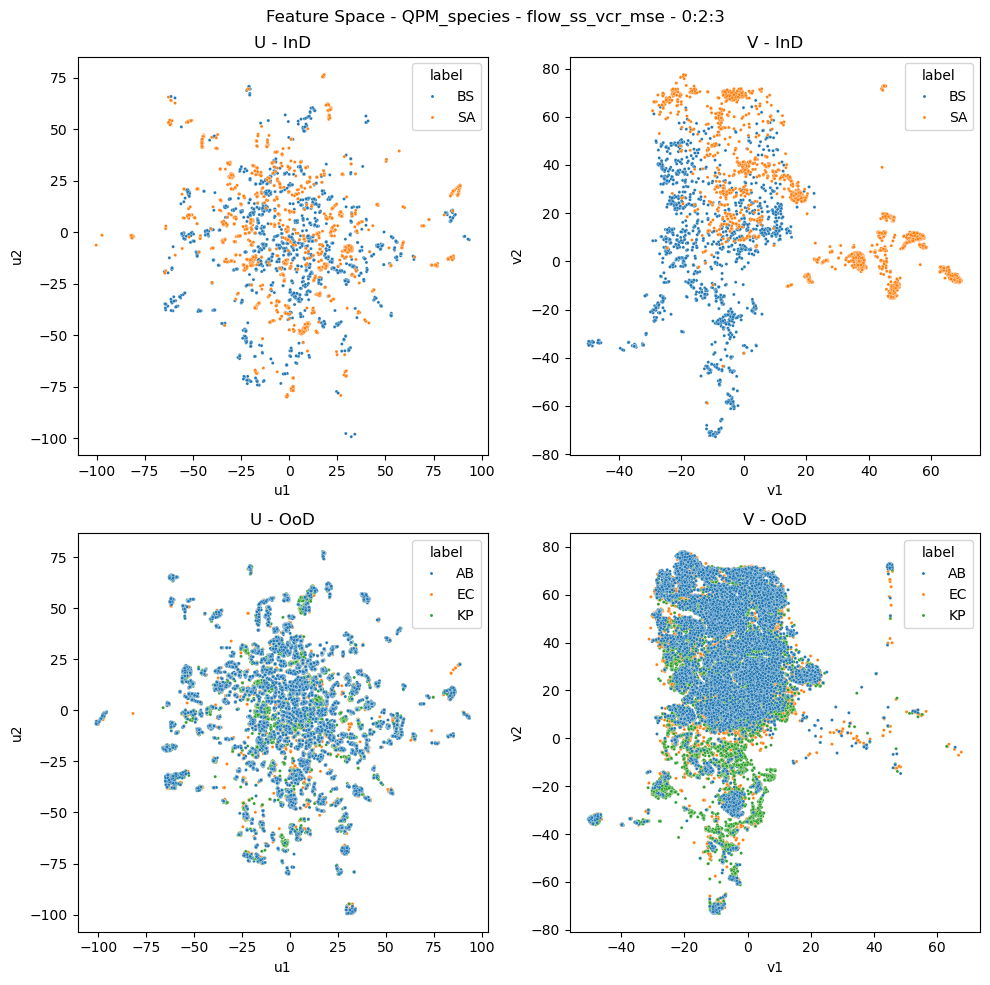

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:02<00:06,  2.14s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:04<00:04,  2.07s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:06<00:02,  2.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:11<00:35, 11.80s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:23<00:23, 11.83s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:35<00:11, 11.89s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 12.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.96s/it]

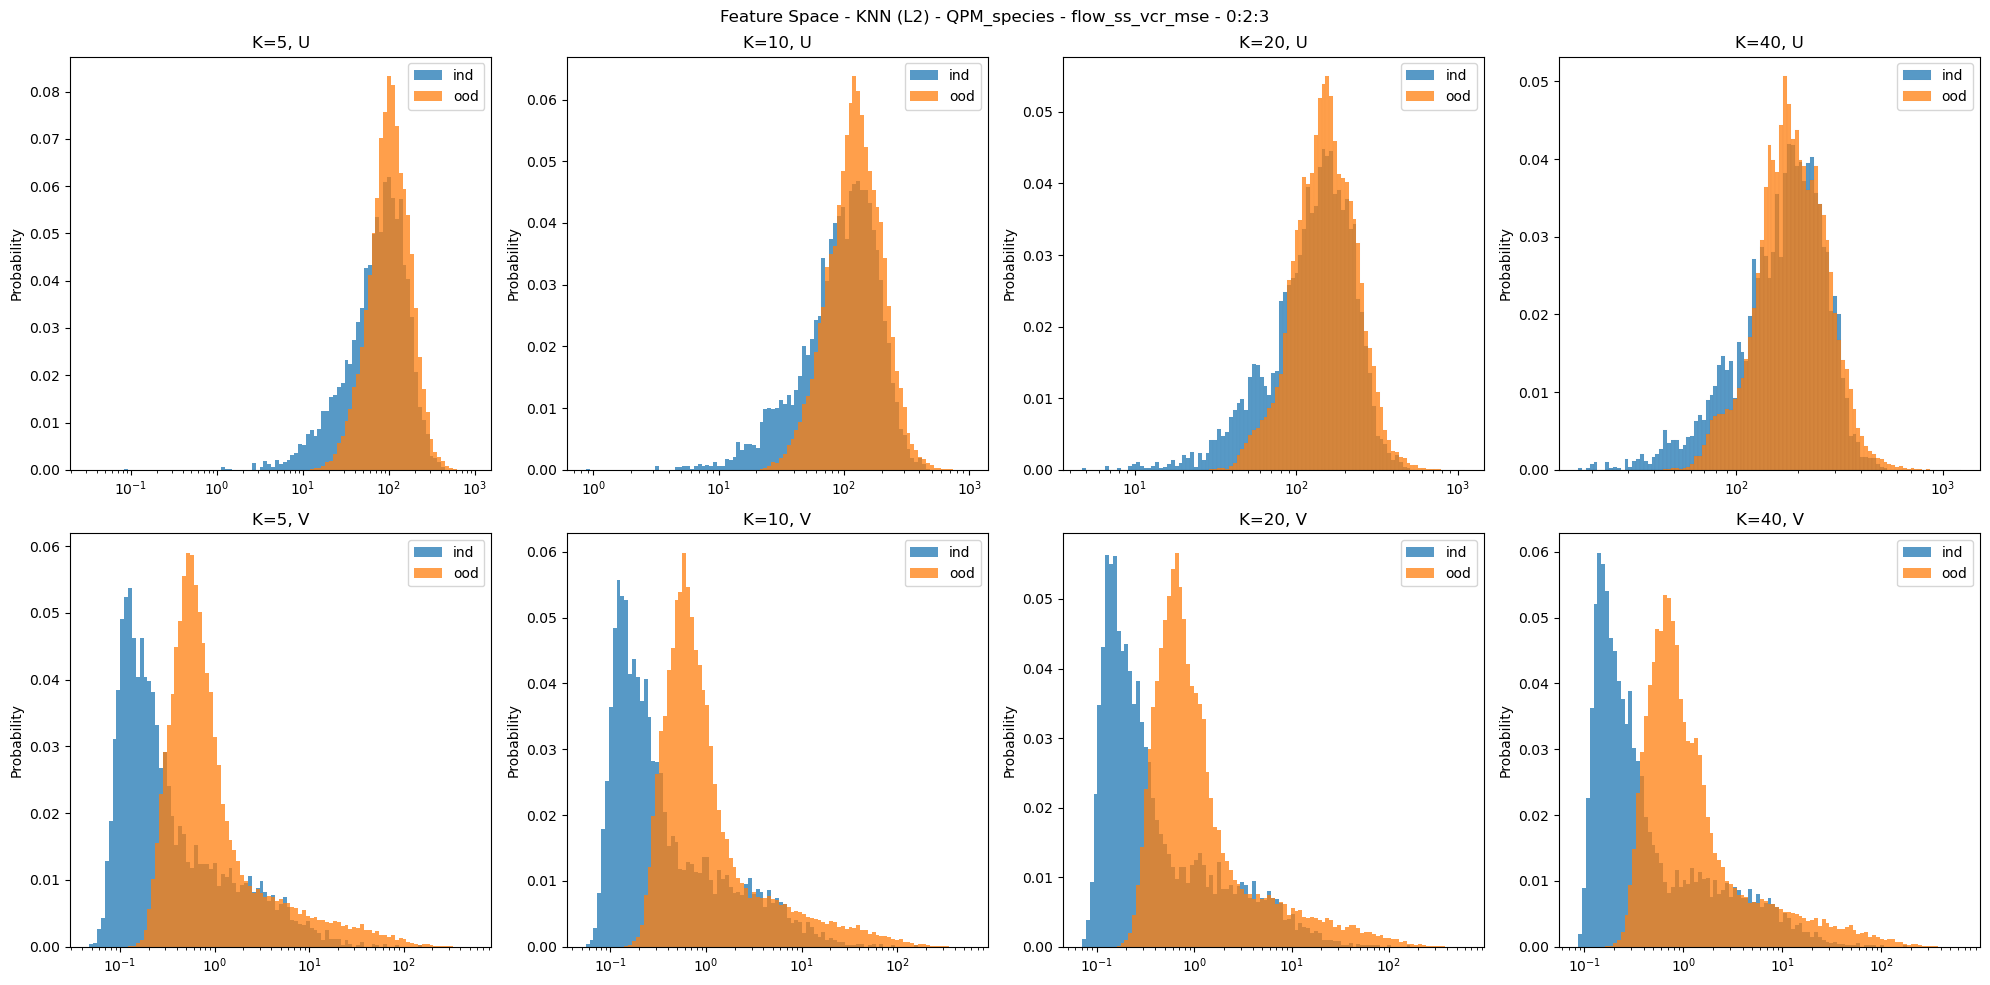

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:01<00:05,  1.95s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:03<00:03,  1.97s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:06<00:02,  2.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]

  0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:11<00:35, 11.71s/it]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 2/4 [00:23<00:23, 11.87s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:35<00:11, 11.85s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.91s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.88s/it]

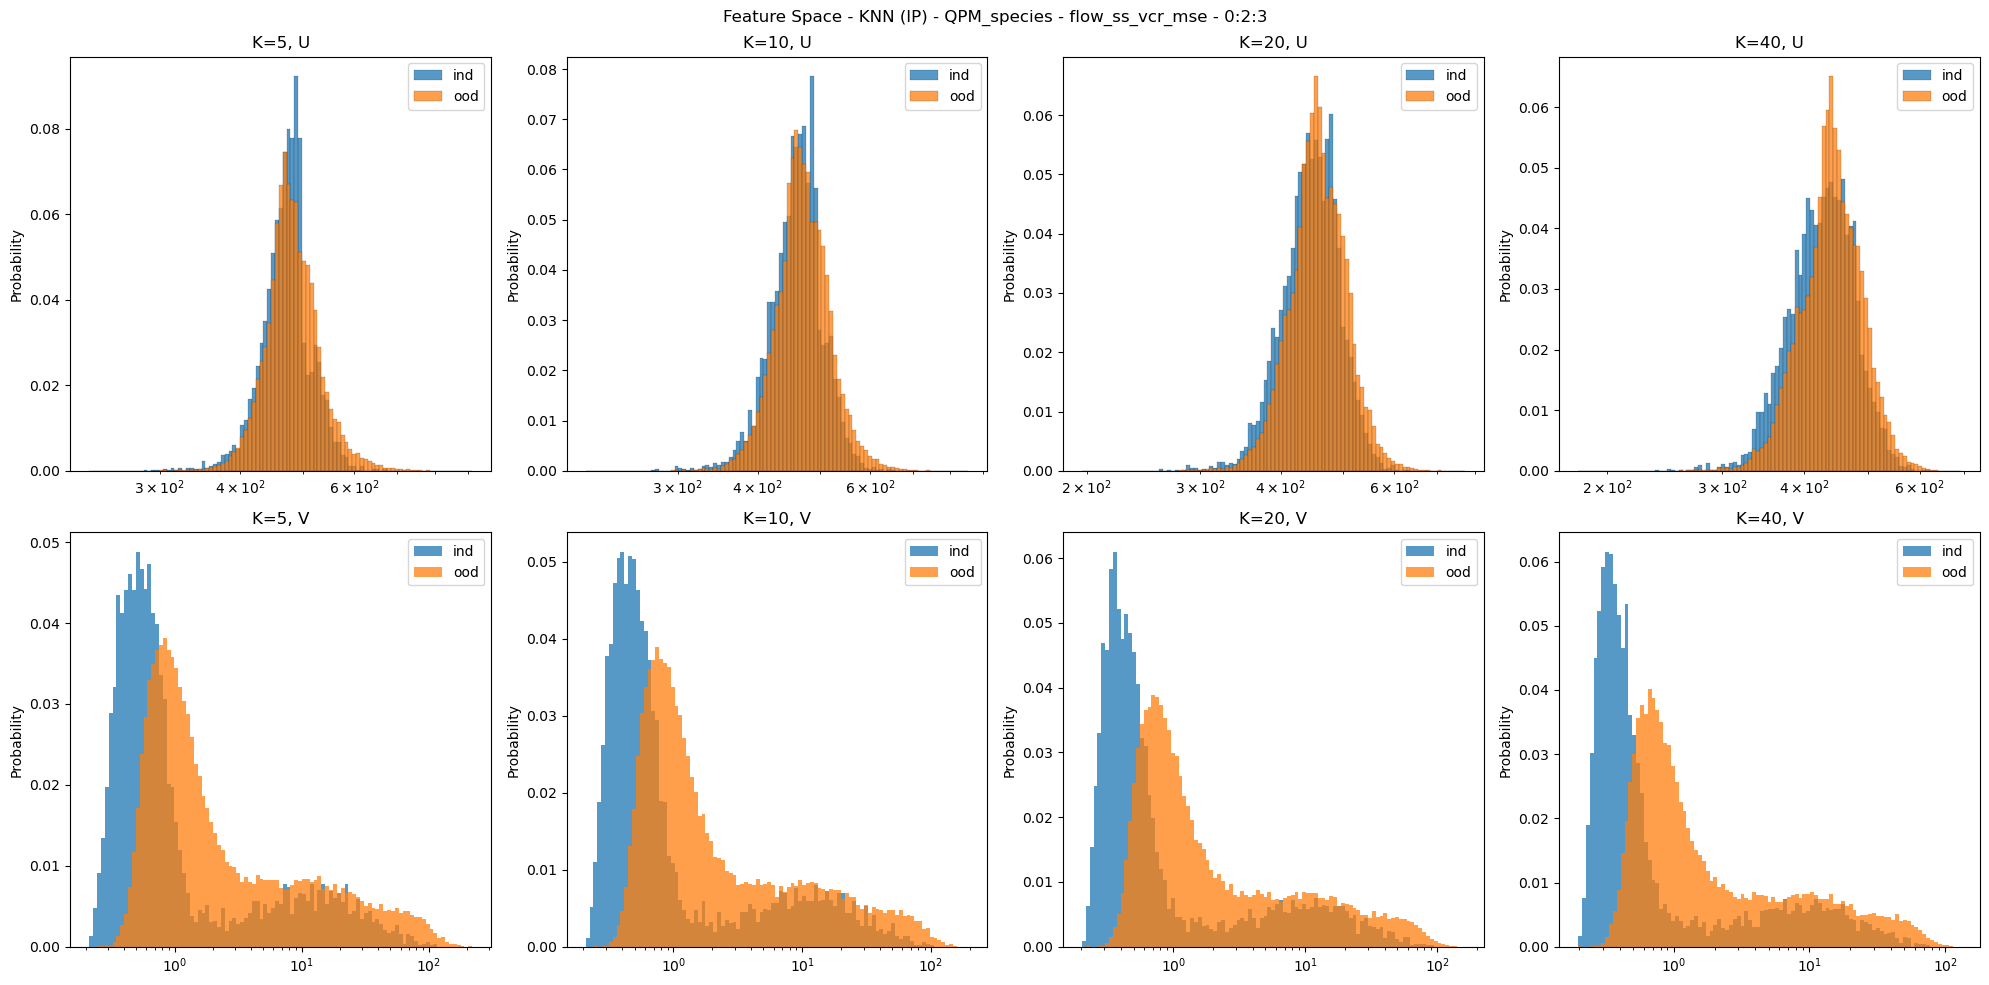

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.743052 0.76500094 1.2581387 1.3692688
22.684183 0.68229264 1.1462793 1.2093445
22.750017 0.7551797 1.2786463 1.3675599
23.255348 1.2497312 2.0060556 2.2396302
34.55469 0.9170529 58.1164 0.75561714


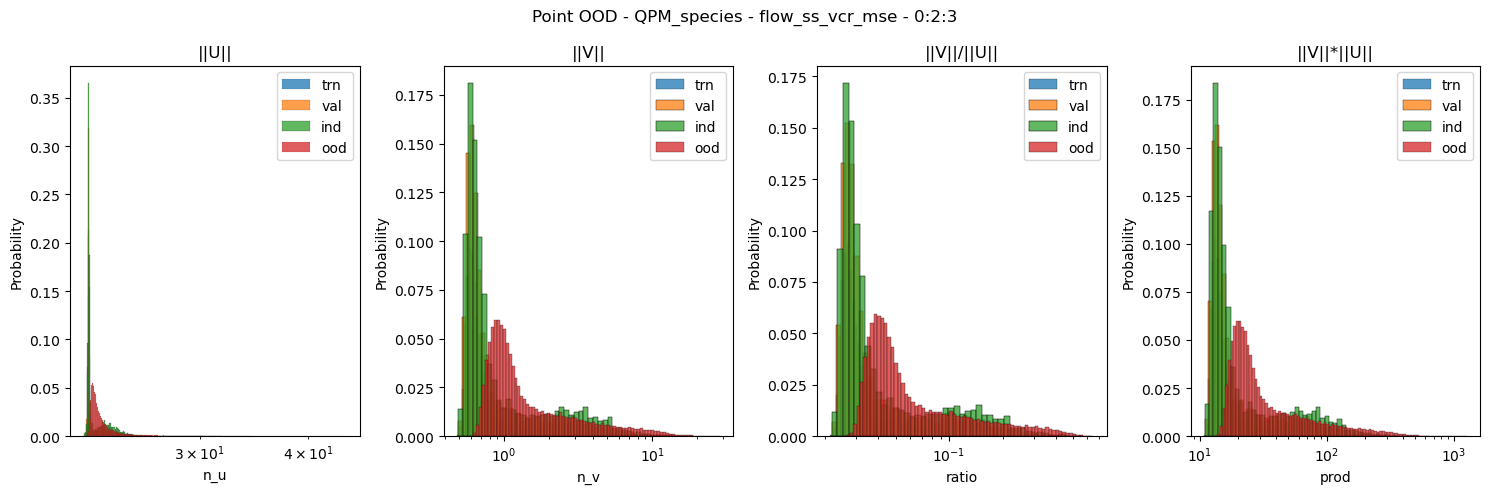

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


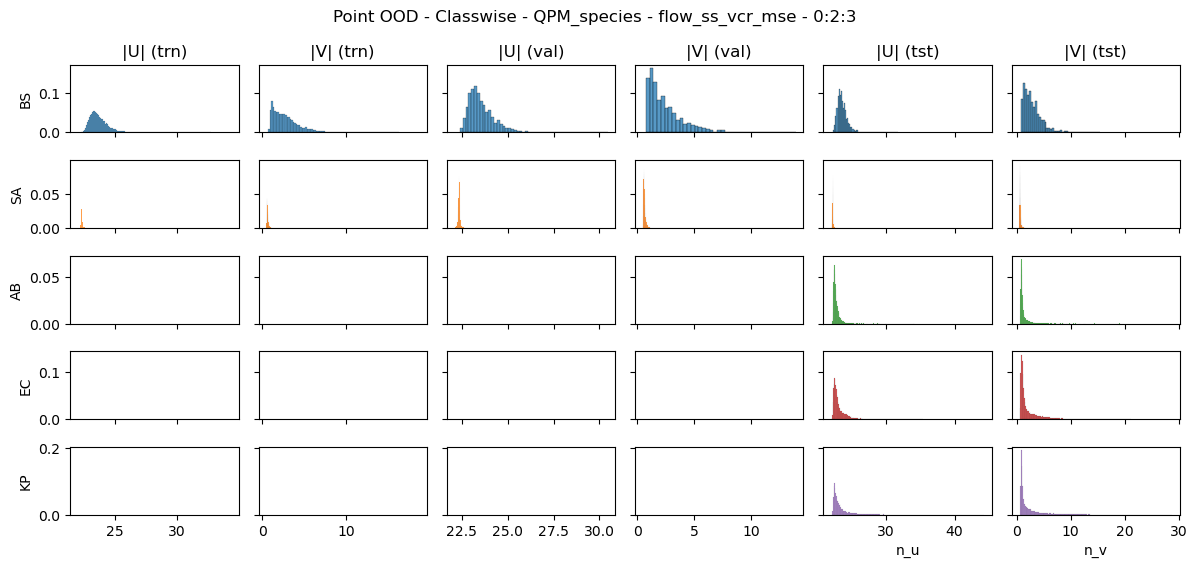

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

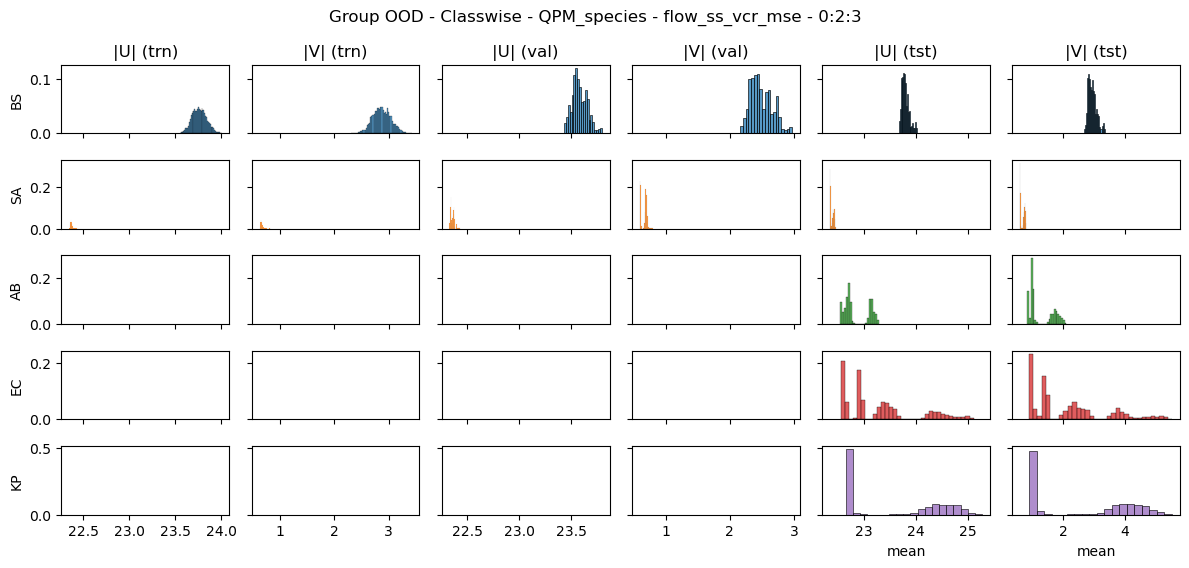

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

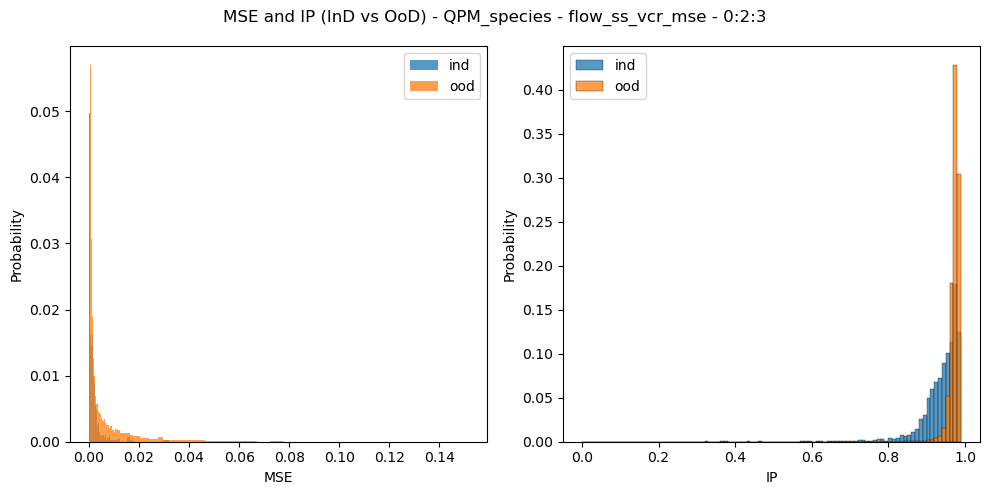

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()